# Demo for 3-Body potentials in JAX-MD

In [1]:
import numpy as onp

import jax.numpy as jnp
from jax import random
from jax import jit, grad, vmap, value_and_grad
from jax import lax
from jax import ops

from jax.config import config
config.update("jax_enable_x64", True)

from jax_md import space, smap, energy, minimize, quantity, simulate, partition, util

from functools import partial
import time
from typing import List

f32 = jnp.float32
f64 = jnp.float64
Array = jnp.ndarray

import matplotlib
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 16})

def format_plot(x, y):  
  plt.grid(True)
  plt.xlabel(x, fontsize=20)
  plt.ylabel(y, fontsize=20)
  
def finalize_plot(shape=(1, 0.7)):
  plt.gcf().set_size_inches(
    shape[0] * 1.5 * plt.gcf().get_size_inches()[1], 
    shape[1] * 1.5 * plt.gcf().get_size_inches()[1])
  plt.tight_layout()

def plot_system(R,box_size,species=None,ms=20):
  R_plt = onp.array(R)

  if(species is None):
    plt.plot(R_plt[:, 0], R_plt[:, 1], 'o', markersize=ms)
  else:
    for ii in range(jnp.amax(species)+1):
      Rtemp = R_plt[species==ii]
      plt.plot(Rtemp[:, 0], Rtemp[:, 1], 'o', markersize=ms)

  plt.xlim([0, box_size])
  plt.ylim([0, box_size])
  plt.xticks([], [])
  plt.yticks([], [])

  finalize_plot((1,1))
  
key = random.PRNGKey(0)

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
2022-06-17 12:11:30.367932: E external/org_tensorflow/tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error


In [2]:
from uf3.forcefield.calculator import *
from uf3.representation import bspline
from uf3.data import composition
from uf3.regression import least_squares

element_list = ['W']
degree = 3

chemical_system = composition.ChemicalSystem(element_list=element_list,
                                             degree=degree)

r_min_map = {("W", "W"): 1.5,
             ("W", "W", "W"): [1.5, 1.5, 1.5],
            }
r_max_map = {("W", "W"): 5.5,
             ("W", "W", "W"): [3.5, 3.5, 7.0],
            }
resolution_map = {("W", "W"): 25,
                  ("W", "W", "W"): [5, 5, 10],
                 }
trailing_trim = 3

bspline_config = bspline.BSplineBasis(chemical_system,
                                      r_min_map=r_min_map,
                                      r_max_map=r_max_map,
                                      resolution_map=resolution_map,
                                      trailing_trim=trailing_trim)

model = least_squares.WeightedLinearModel(bspline_config)

model.load(filename="../tungsten_extxyz/model_uf23.json")

calc = UFCalculator(model)

ndspline2 = calc.pair_potentials[('W','W')]
ndspline3 = calc.trio_potentials[('W','W','W')]

In [4]:
coefficients2 = jnp.asarray(ndspline2.coefficients)
coefficients2 = coefficients2[:,0]

knots2 = ndspline2.knots
knots2 = knots2[0]

print(coefficients2.shape)

print(knots2)

(28,)
[1.5  1.5  1.5  1.5  1.66 1.82 1.98 2.14 2.3  2.46 2.62 2.78 2.94 3.1
 3.26 3.42 3.58 3.74 3.9  4.06 4.22 4.38 4.54 4.7  4.86 5.02 5.18 5.34
 5.5  5.5  5.5  5.5 ]


In [3]:
coefficients3 = jnp.asarray(ndspline3.coefficients)
coefficients3 = coefficients3[:,:,:,0]

knots3 = ndspline3.knots
knots3 = [jnp.asarray(i) for i in knots3]

print(coefficients3.shape)

print(knots3)

(8, 8, 13)
[DeviceArray([1.5, 1.5, 1.5, 1.5, 1.9, 2.3, 2.7, 3.1, 3.5, 3.5, 3.5, 3.5],            dtype=float64), DeviceArray([1.5, 1.5, 1.5, 1.5, 1.9, 2.3, 2.7, 3.1, 3.5, 3.5, 3.5, 3.5],            dtype=float64), DeviceArray([1.5 , 1.5 , 1.5 , 1.5 , 2.05, 2.6 , 3.15, 3.7 , 4.25, 4.8 ,
             5.35, 5.9 , 6.45, 7.  , 7.  , 7.  , 7.  ], dtype=float64)]


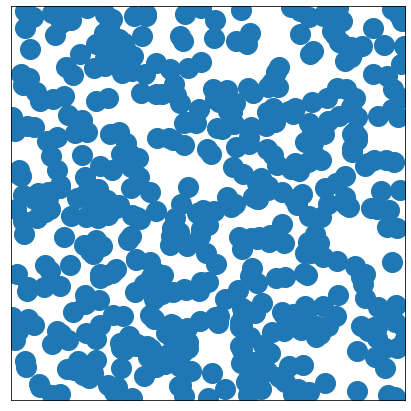

In [5]:
N = 500
dimension = 3
box_size = 12.0

key, split = random.split(key)
R = random.uniform(split, (N,dimension), minval=0.0, maxval=box_size, dtype=f64) 

plot_system(R,box_size)

In [6]:
box = jnp.eye(dimension) * box_size
displacement, shift = space.periodic_general(box, fractional_coordinates=False)

In [7]:
neighbour_fn, compute_fn = energy.lennard_jones_neighbor_list(displacement, box_size)
nbrs = neighbour_fn.allocate(R)
print(compute_fn(R, nbrs))

300248526157.9771


In [8]:
neighbour_fn, compute_fn = energy.stillinger_weber_neighbor_list(displacement, box_size)
nbrs = neighbour_fn.allocate(R)
print(compute_fn(R, nbrs))

1590483.1270676518


## 3-body ufp Potential

In [9]:
from uf3.jax.potentials import uf3_interaction, uf3_mapped

In [10]:

uf3 = partial(uf3_interaction, coefficients=coefficients3, knots=knots3)
uf3m = partial(uf3_mapped, coefficients=coefficients3, knots=knots3)

In [11]:
dR12 = jnp.asarray([[2.0,0.0,0.0],[0.0,2.5,0.0]])
dR13 = jnp.asarray([[0.0,2.5,0.0],[2.0,0.0,0.0]])

In [12]:
import jax_md.space

k = 3
cutoff = knots3[0][-k-1]

angular_cutoff = cutoff * 2

dR23 = dR13 - dR12
dr12 = space.distance(dR12)
dr13 = space.distance(dR13)
dr23 = space.distance(dR23)
dr12 = jnp.where(dr12 < cutoff, dr12, 0)
dr13 = jnp.where(dr13 < cutoff, dr13, 0)
dr23 = jnp.where(dr23 < angular_cutoff, dr23, 0)

In [13]:
print(dr23)

[3.20156212 3.20156212]


In [14]:
import uf3.jax.jax_splines as jsp
k = 3
spline1 = jit(vmap(partial(jsp.deBoor_factor_unsafe, k, knots3[0])))
spline2 = jit(vmap(partial(jsp.deBoor_factor_unsafe, k, knots3[1])))
spline3 = jit(vmap(partial(jsp.deBoor_factor_unsafe, k, knots3[2])))

In [15]:
print(spline1(dr12).shape)

(2, 8)


In [16]:
jnp.einsum(coefficients3, [1,2,3], spline1(dr12), [4,1], spline2(dr13), [4,2], spline3(dr23), [4,3],[4])

DeviceArray([0.03746806, 0.03746806], dtype=float64)

In [17]:
uf3(dR12[0],dR13[0])
test = vmap(uf3)
test(dR12, dR13)

DeviceArray([0.03746806, 0.03746806], dtype=float64)

In [18]:
R[:5]

DeviceArray([[11.07303225,  7.30698128,  6.30687587],
             [ 2.71739632,  7.13126088, 10.53086086],
             [ 5.13914779,  0.4230908 ,  5.88431467],
             [ 3.16696723, 10.81587555,  6.7190383 ],
             [ 8.32987093,  4.79927217, 10.27326279]], dtype=float64)

In [26]:
dR = space.map_product(displacement)(R,R)
# print(dR[0])

test = vmap(vmap(vmap(uf3, (0,None)),(None, 0)))

jnp.sum(test(dR,dR))

2022-06-03 14:45:53.553843: W external/org_tensorflow/tensorflow/core/common_runtime/bfc_allocator.cc:462] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.79GiB (rounded to 3000000000)requested by op 
2022-06-03 14:45:53.553990: W external/org_tensorflow/tensorflow/core/common_runtime/bfc_allocator.cc:474] *___________________________________________________________________________________________________
2022-06-03 14:45:53.554067: E external/org_tensorflow/tensorflow/compiler/xla/pjrt/pjrt_stream_executor_client.cc:2086] Execution of replica 0 failed: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 3000000000 bytes.
BufferAssignment OOM Debugging.
BufferAssignment stats:
             parameter allocation:   11.44MiB
              constant allocation:         0B
        maybe_live_out allocation:    2.79GiB
     preallocated temp allocation:         0B
                 total allocation:    2.80GiB
              total fragmentation:         0B (0.00%)
Peak buffe

RuntimeError: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 3000000000 bytes.
BufferAssignment OOM Debugging.
BufferAssignment stats:
             parameter allocation:   11.44MiB
              constant allocation:         0B
        maybe_live_out allocation:    2.79GiB
     preallocated temp allocation:         0B
                 total allocation:    2.80GiB
              total fragmentation:         0B (0.00%)
Peak buffers:
	Buffer 1:
		Size: 2.79GiB
		Operator: op_type="sub" op_name="jit(vmap(vmap(vmap(<lambda>))))/sub" source_file="/home/robert/repositories/github.com/Robert-Schmid/uf3/uf3/jax/potentials.py" source_line=188
		XLA Label: fusion
		Shape: f64[500,500,500,3]
		==========================

	Buffer 2:
		Size: 5.72MiB
		Entry Parameter Subshape: f64[500,500,3]
		==========================

	Buffer 3:
		Size: 5.72MiB
		Entry Parameter Subshape: f64[500,500,3]
		==========================



In [25]:
jnp.sum(test(dR / 2.0,dR / 2.0))

DeviceArray(0.56005353, dtype=float64)

In [21]:
d = displacement
dR = space.map_product(d)(R, R)

In [22]:
space.distance(dR).shape

(500, 500)

In [49]:
def uf3_mapped(dR12, dR13, coefficients=None, knots=None):
    fn = partial(uf3_interaction,coefficients=coefficients, knots=knots)
    return vmap(vmap(fn, (0, None)), (None, 0))(dR12, dR13)

uf3_co = lambda c: uf3_mapped(dR,dR,coefficients=c, knots=knots3)

gamma = 1.2
sigma = 2.0951
cutoff = 3.77118
three_body_fn = partial(energy._sw_angle_interaction, gamma, sigma, cutoff)
three_body_fn = vmap(vmap(vmap(three_body_fn, (0, None)), (None, 0)))
sw = three_body_fn(dR,dR)

In [54]:
sw.size

3375000

In [36]:
grad(uf3_co)(coefficients3)[0,0]

DeviceArray([1.26810841e+02, 1.93819270e+02, 2.64316239e+02,
             4.83067776e+02, 4.36063027e+02, 8.01238060e+01,
             3.82680522e-01, 1.19977661e-11, 0.00000000e+00,
             0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
             0.00000000e+00], dtype=float64)

In [55]:
def loss(coefficients):
    return util.high_precision_sum( (sw - uf3_co(coefficients)) ** 2 / sw.size )

In [56]:
loss(coefficients3)

DeviceArray(175.31473834, dtype=float64)

In [57]:
c = jnp.zeros_like(coefficients3)
loss_fn = jit(grad(loss))
lossJ = jit(loss)

for i in range(100):
    dc = loss_fn(c)
    c -= dc

    # if i % 10 == 0:
    print(lossJ(c))

9.892412537145563e-05
9.832708505606649e-05
9.775766192719095e-05
9.721456118953537e-05
9.6696549322158e-05
9.620245115752307e-05
9.573114710061123e-05
9.528157048133955e-05
9.485270503387057e-05
9.444358249669808e-05
9.40532803276967e-05
9.36809195285988e-05
9.332566257363451e-05
9.298671143732015e-05
9.266330571662754e-05
9.235472084299307e-05
9.20602663798464e-05
9.177928440154806e-05
9.151114794982185e-05
9.12552595639577e-05
9.101104988124162e-05
9.077797630423791e-05
9.055552173171381e-05
9.034319335015064e-05
9.014052148293257e-05
8.994705849444548e-05
8.976237774645017e-05
8.958607260422366e-05
8.941775549008053e-05
8.925705698200245e-05
8.910362495521444e-05
8.895712376464855e-05
8.881723346633624e-05
8.868364907586522e-05
8.855607986212411e-05
8.843424867464746e-05
8.83178913029506e-05
8.820675586632537e-05
8.810060223263794e-05
8.79992014647419e-05
8.790233529318677e-05
8.780979561396403e-05
8.772138401009377e-05
8.76369112959146e-05
8.755619708298955e-05
8.747906936659845e-

In [58]:
c[0,0,0]

DeviceArray(0.00015426, dtype=float64)